<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I8kDikouqpH4hf7JBiSYAeNT2IO52T-T" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Весна 2021</b></h3>

# Сегментация изображений

В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов. 

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




# Оглавление

1. [SegNet](#SegNet-[2-балла])
2. [Метрика Intersection over Union (Коэффициент Жаккара)](#Метрика)
3. [BCE Loss](#Функция-потерь-[1-балл])
4. [Функция обучения](#Тренировка-[1-балл])
5. [Инференс](#Инференс-[1-балл])
6. [Обучение](#Основной-момент:-обучение)
7. [Дополнительные функции потерь](#Дополнительные-функции-потерь-[2-балла])
8. [Мир сегментационных лоссов](#[BONUS]-Мир-сегментационных-лоссов-[5-баллов])
9. [U-Net](#U-Net-[2-балла])
10. [Отчет](#Отчет-(6-баллов):)

---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>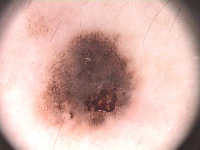</td><td>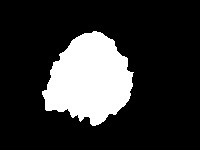</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

In [1]:
# ! wget https://www.dropbox.com/s/k88qukc20ljnbuo/PH2Dataset.rar

In [2]:
# get_ipython().system_raw("unrar x PH2Dataset.rar")

Структура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [3]:
from tqdm.notebook import tqdm
from time import time

from skimage.io import imread
from skimage.transform import resize
import os
import copy
import numpy as np

from IPython.display import clear_output

from torch.utils.data import DataLoader
import torch
import torch.nn as nn
from torchvision import models
import torch.optim as optim
from torchsummary import summary

import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (20, 10)

In [4]:
images = []
lesions = []

root = '../data/PH2Dataset'

for path, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if path.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(path, files[0])))
    if path.endswith('_lesion'):
        lesions.append(imread(os.path.join(path, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [5]:
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [6]:
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Loaded 200 images


In [7]:
len(lesions)

200

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

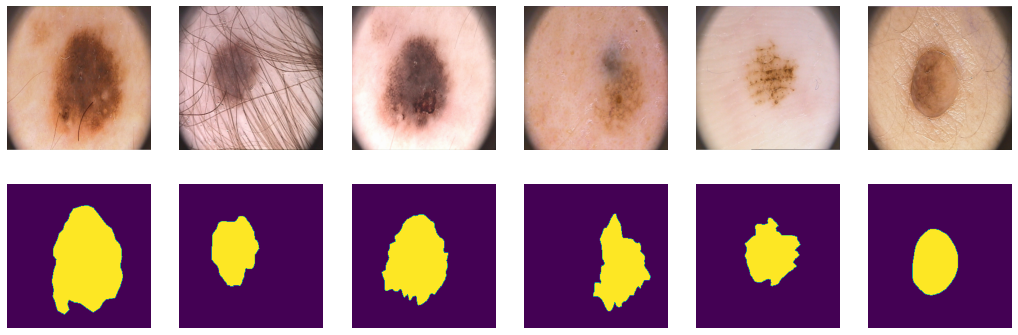

In [8]:
plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [9]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [10]:
print(len(tr), len(val), len(ts))

100 50 50


#### PyTorch DataLoader

In [11]:
batch_size = 4
data_tr = DataLoader(list(zip(np.moveaxis(X[tr], 3, 1), Y[tr, np.newaxis])), 
                     batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.moveaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
data_ts = DataLoader(list(zip(np.moveaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

In [12]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

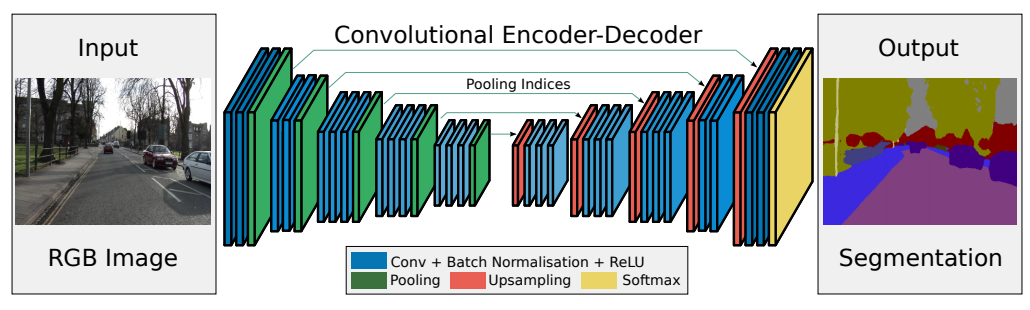

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [13]:
# from torchvision import models

# models.vgg16()

In [14]:
# summary(models.vgg16(), (3, 256, 256))

<a id='segnet'></a>

In [15]:
class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2, return_indices=True) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.MaxUnpool2d(kernel_size=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.MaxUnpool2d(kernel_size=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.MaxUnpool2d(kernel_size=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.MaxUnpool2d(kernel_size=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0, i_pool0 = self.pool0(self.enc_conv0(x))
        e1, i_pool1 = self.pool1(self.enc_conv1(e0))
        e2, i_pool2 = self.pool2(self.enc_conv2(e1))
        e3, i_pool3 = self.pool3(self.enc_conv3(e2))

        # bottleneck
        b = self.bottleneck_conv(e3)

        # decoder
        d0 = self.dec_conv0(self.upsample0(b, i_pool3))
        d1 = self.dec_conv1(self.upsample1(d0, i_pool2))
        d2 = self.dec_conv2(self.upsample2(d1, i_pool1))
        d3 = self.dec_conv3(self.upsample3(d2, i_pool0)) # no activation
        return d3

## Метрика

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

In [16]:
def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
    # You can comment out this line if you are passing tensors of equal shape
    # But if you are passing output from UNet or something it will most probably
    # be with the BATCH x 1 x H x W shape
    outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
    labels = labels.squeeze(1).byte()
    SMOOTH = 1e-8
    intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
    union = (outputs | labels).float().sum((1, 2))         # Will be zero if both are 0
    
    iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0
    
#     thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds
    
#     return thresholded  # 
    return iou

## Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации. 

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$
<a id='bce_loss'></a>

In [17]:
def bce_loss(y_real, y_pred):
    # please don't use nn.BCELoss. write it from scratch
#     return (-y_pred - y_pred * y_real + torch.log(1 + torch.exp(-y_pred))).mean()
#     return (torch.max(y_pred, 0) - y_pred * y_real + torch.log(1 + torch.exp(-abs(y_pred)))).mean()
    return (-y_real * y_pred + torch.log(1 + torch.exp(y_real))).mean()

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [18]:
def train(model, opt, loss_fn, epochs, data_tr, data_val, metric, threshold=0.5):
    history = {'tr_loss': [], 'tr_acc': [], 'val_loss': [], 'val_acc': []}
    best_acc = 0
    X_val, Y_val = next(iter(data_val))

    for epoch in range(epochs):
        tic = time()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        tr_loss, tr_acc, val_loss, val_acc = 0, 0, 0, 0
        model.train() # train mode
        for X_batch, Y_batch in tqdm(data_tr):
            # data to device
            X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
            # set parameter gradients to zero
            opt.zero_grad()
            # forward
            Y_pred = model(X_batch)
            loss = loss_fn(Y_batch, Y_pred) # forward-pass
            loss.backward() # backward-pass
            opt.step() # update weights

            # calculate loss to show to the user
            tr_loss += loss / len(data_tr)
            # calculate acc
#             means = Y_pred.mean((2, 3)).unsqueeze(-1).unsqueeze(-1)
#             Y_pred_bin = (Y_pred > means).float()
            Y_pred_bin = (torch.sigmoid(Y_pred) > threshold).float()
            acc = metric(Y_pred_bin, Y_batch).mean().item()
            tr_acc += acc / len(data_tr)
        toc = time()
        print('loss: %f' % tr_loss)

        # show intermediate results
        model.eval() # testing mode
        with torch.no_grad():
            Y_hat = model(X_val.to(device)).detach().to('cpu') # detach and put into cpu
            for X_batch, Y_batch in data_val:
                X_batch, Y_batch = X_batch.to(device), Y_batch.to(device)
                Y_pred = model(X_batch)
                loss = loss_fn(Y_batch, Y_pred)
                val_loss += loss / len(data_val)
#                 means = Y_pred.mean((2, 3)).unsqueeze(-1).unsqueeze(-1)
#                 Y_pred_bin = (Y_pred > means).float()
                Y_pred_bin = (torch.sigmoid(Y_pred) > threshold).float()
                acc = metric(Y_pred_bin, Y_batch).mean().item()
                val_acc += acc / len(data_val)
        history['tr_loss'].append(tr_loss)
        history['tr_acc'].append(tr_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        # save best model
        if val_acc > best_acc:
            best_acc = val_acc
            best_model_wts = copy.deepcopy(model.state_dict())

        # Visualize tools
        clear_output(wait=True)
        for k in range(4):
            plt.subplot(3, 6, k+1)
            plt.imshow(np.moveaxis(X_val[k].numpy(), 0, 2), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(3, 6, k+7)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
            
            plt.subplot(3, 6, k+13)
            plt.imshow(np.moveaxis(Y_val[k].numpy(), 0, 2), cmap='gray')
            plt.title('Target')
            plt.axis('off')
        plt.suptitle('%d / %d - Val IoU: %f' % (epoch+1, epochs, val_acc))
        
        fig, (ax1, ax2) = plt.subplots(1, 2)
        ax1.plot(history['tr_loss'], label='train loss')
        ax1.plot(history['val_loss'], label='val loss')
        ax1.set_xlabel("epochs")
        ax1.set_ylabel("loss")
        ax1.legend(loc='best')
        ax1.set_title('Loss plots')
        
        ax2.plot(history['tr_acc'], label='train IoU')
        ax2.plot(history['val_acc'], label='val IoU')
        ax2.set_xlabel("epochs")
        ax2.set_ylabel("IoU")
        ax2.legend(loc='best')
        ax2.set_title('IoU plots')
        
        plt.show()
        
    model.load_state_dict(best_model_wts)
    return model

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [19]:
def predict(model, X_batch, threshold=0.5):
    model.eval()  # testing mode
    with torch.no_grad():
#         Y_pred = [model(X_batch) for X_batch, _ in data]
        Y_pred = model(X_batch)
#         means = Y_pred.mean((2, 3)).unsqueeze(-1).unsqueeze(-1)
    
#     return (Y_pred > means).float()
#     return (Y_pred - Y_pred.min((2, 3)) / (Y_pred.max((2, 3)) - Y_pred.min((2, 3)))).float()
    return (torch.sigmoid(Y_pred) > threshold).float()

In [502]:
def score_model(model, metric, data, threshold=0.5):
    model.eval()  # testing mode
    scores = 0
    for X_batch, Y_label in data:
        Y_pred = predict(model, X_batch.to(device), threshold)
        m = metric(Y_pred, Y_label.to(device)).mean().item()
#         print(m)
        scores += m

    return scores / len(data)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [21]:
model = SegNet().to(device)

In [22]:
summary(model, (3, 256, 256));

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [-1, 64, 256, 256]        --
|    └─Conv2d: 2-1                       [-1, 64, 256, 256]        1,792
|    └─BatchNorm2d: 2-2                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-3                         [-1, 64, 256, 256]        --
|    └─Conv2d: 2-4                       [-1, 64, 256, 256]        36,928
|    └─BatchNorm2d: 2-5                  [-1, 64, 256, 256]        128
|    └─ReLU: 2-6                         [-1, 64, 256, 256]        --
├─MaxPool2d: 1-2                         [-1, 64, 128, 128]        --
├─Sequential: 1-3                        [-1, 128, 128, 128]       --
|    └─Conv2d: 2-7                       [-1, 128, 128, 128]       73,856
|    └─BatchNorm2d: 2-8                  [-1, 128, 128, 128]       256
|    └─ReLU: 2-9                         [-1, 128, 128, 128]       --
|    └─Conv2d: 2-10                      [-1, 128, 128, 128]       147,

<a id='segnet_bce'></a>

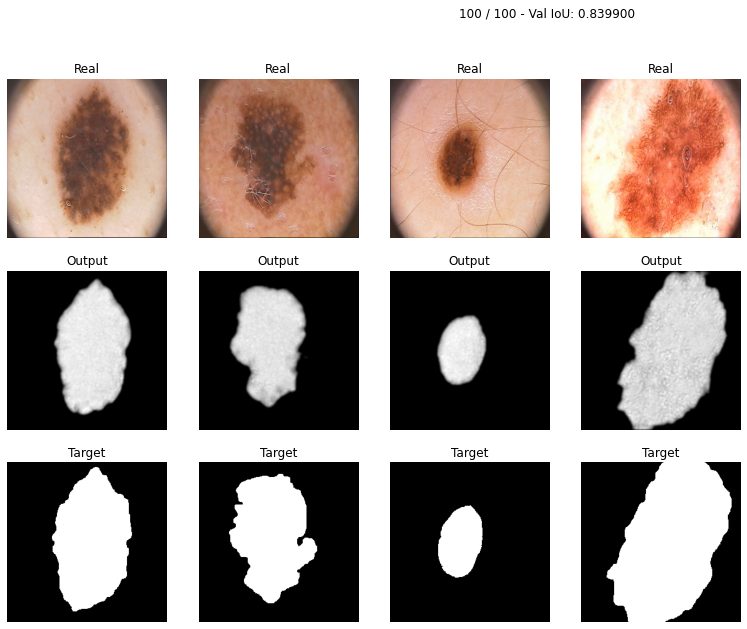

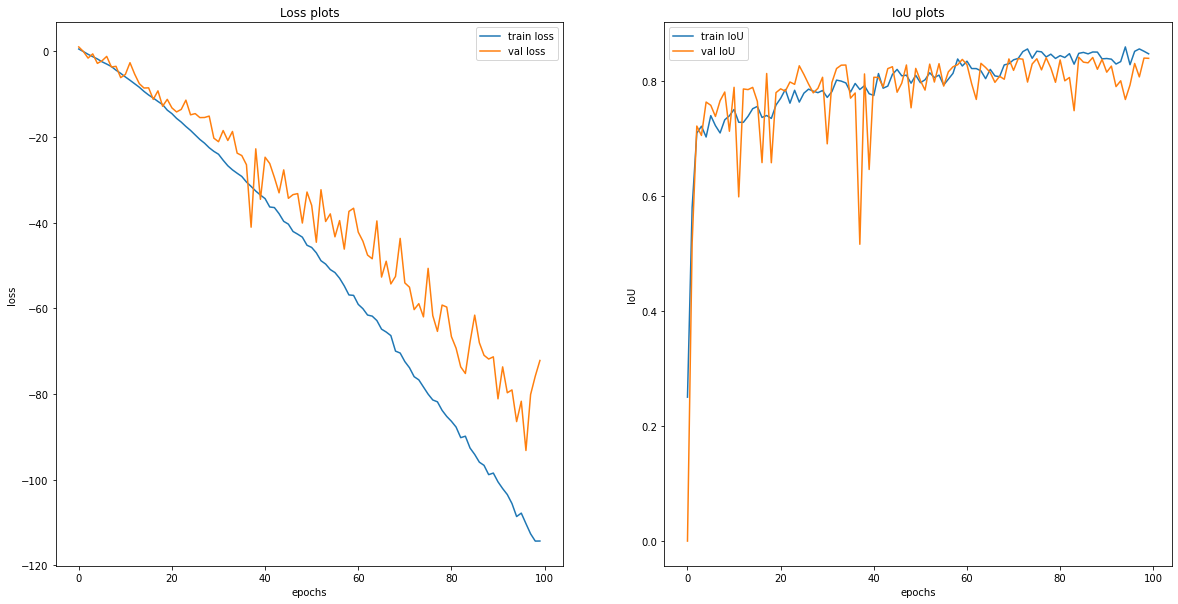

In [23]:
max_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
best_model_segnet_bce = train(model, optimizer, bce_loss, max_epochs, data_tr, data_val, iou_pytorch, threshold=0.9)

In [509]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_segnet_bce, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean score: 0.27048375643216643


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean score: 0.27063467465914215


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean score: 0.2709655438936673


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean score: 0.2708358119084285


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean score: 0.27088549393873934


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean score: 0.837635187690075


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean score: 0.8379809192052253


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean score: 0.8385114805514995


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean score: 0.8400534378565276


In [525]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_segnet_bce, iou_pytorch, data_ts, threshold=0.9)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8422524918042699


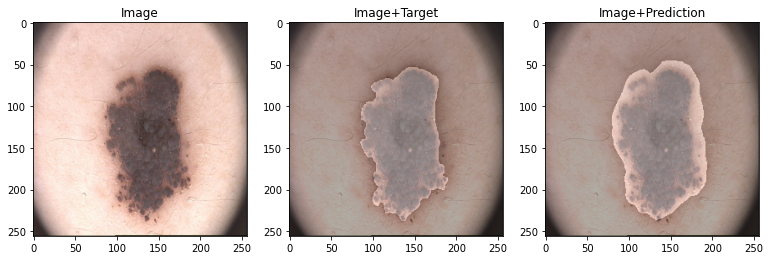

In [512]:
# бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_segnet_bce, X.to(device), threshold=0.9)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [318]:
# torch.save(best_model_segnet_bce.state_dict(), 'SegNet_BCE.pth')

Проверены 2 способа анпулинга:
- upsample
- maxunpooling

В обоих случаях достигалась точность ~0.7 (40 эпох). В случае с upsample требуется меньше эпох.

Ответьте себе на вопрос: не переобучается ли моя модель?

-----------------------------------------------------------------------------------------

## Дополнительные функции потерь [2 балла] 

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss. 
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-\frac{1}{256 \times 256} \times \sum_i\frac{2X_iY_i}{X_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.
<a id='dice_loss'></a>

In [65]:
def dice_loss(y_real, y_pred):
#     y_real = y_real.view(-1)
#     y_pred = y_pred.view(-1)
#     y_pred_sigm = torch.clamp(y_pred, 0, 1) # результат лучше 0.72
    y_pred_sigm = torch.sigmoid(y_pred) # 0.68
    smooth = 1.
    num = 2 * (y_real * y_pred_sigm).sum() + smooth
    den = y_real.sum() + y_pred_sigm.sum() + smooth
    res = num / den
    return 1 - res

Проводим тестирование:

In [66]:
model = SegNet().to(device)

<a id='segnet_dice'></a>

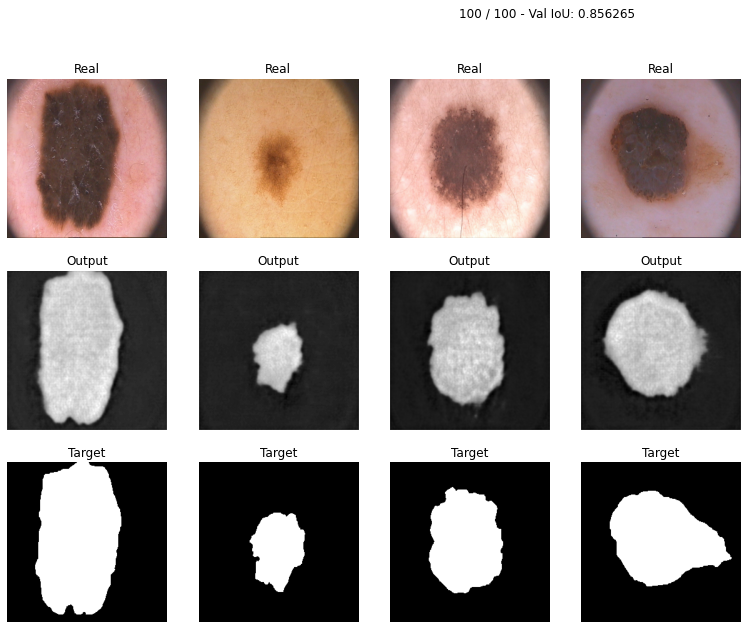

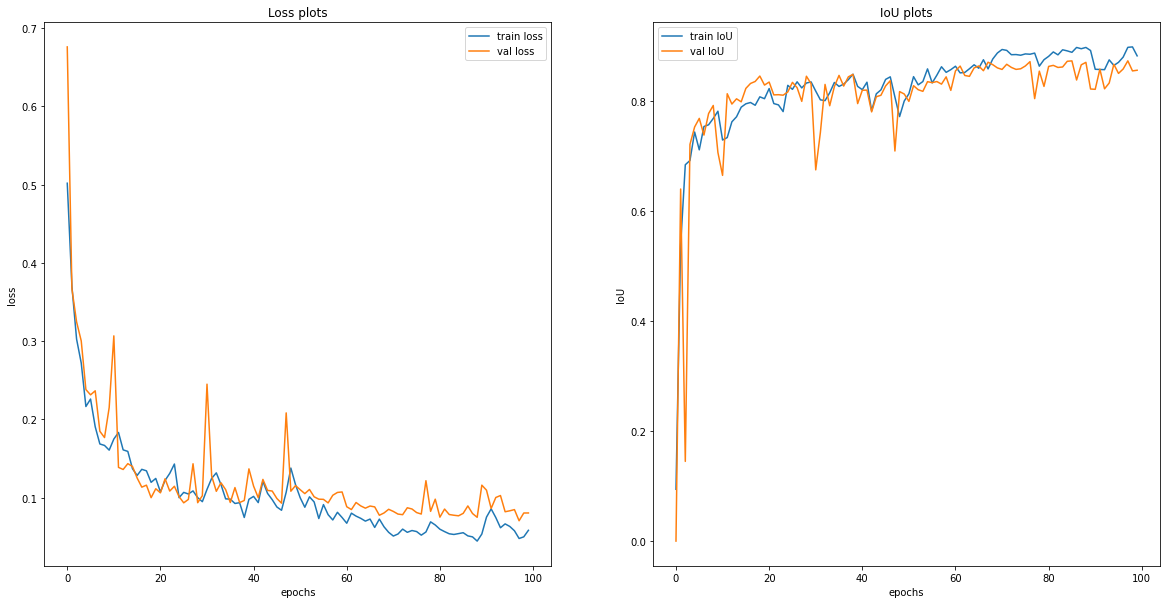

In [67]:
max_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
best_model_segnet_dice = train(model, optimizer, dice_loss, max_epochs, data_tr, data_val, iou_pytorch, threshold=0.9)

In [513]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_segnet_dice, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.8626084433152122


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.8651214930644404


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.8659595014957278


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.8674823132845071


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.868031084720905


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.8682229519807376


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8695315290414365


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.870585686518596


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.8717389968266851


In [526]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_segnet_dice, iou_pytorch, data_ts, threshold=0.9)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8730062550764818


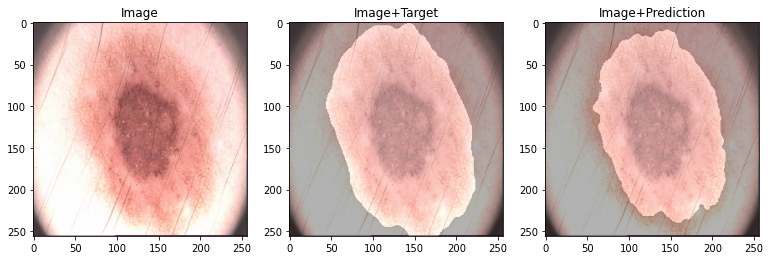

In [515]:
# бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_segnet_dice, X.to(device), threshold=0.9)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [319]:
# torch.save(best_model_segnet_dice.state_dict(), 'SegNet_Dice.pth')

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf) 

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------
<a id='focal_loss'></a>

In [100]:
def focal_loss(y_real, y_pred, eps=1e-8, gamma=0):
#     y_pred_sigm = torch.clamp(y_pred, 0, 1)
    y_pred_sigm = torch.sigmoid(y_pred)
    focal_loss = (1 - y_pred_sigm)**gamma * y_real * torch.log(y_pred_sigm + eps) + \
                                                    (1 - y_real) * torch.log(1 - y_pred_sigm + eps)
    
    #first compute binary cross-entropy 
#     BCE = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='mean')
#     BCE_EXP = torch.exp(-BCE)
#     focal_loss = 0.8 * (1-BCE_EXP)**gamma * BCE
#     pt = torch.exp(y_pred)
#     focal_loss = -0.8 * (1 - pt)**gamma * torch.log(pt)
    
#     BCE_loss = F.binary_cross_entropy_with_logits(y_pred, y_real, reduction='none')
#     pt = torch.exp(-BCE_loss)
#     F_loss = 0.8*(1-pt)**gamma * BCE_loss
    return -focal_loss.mean()

In [101]:
model = SegNet().to(device)

<a id='segnet_focal'></a>

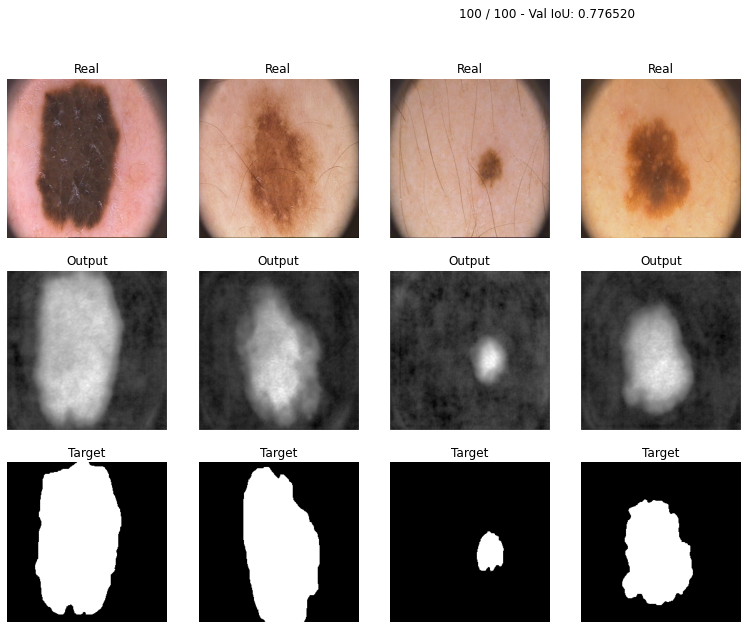

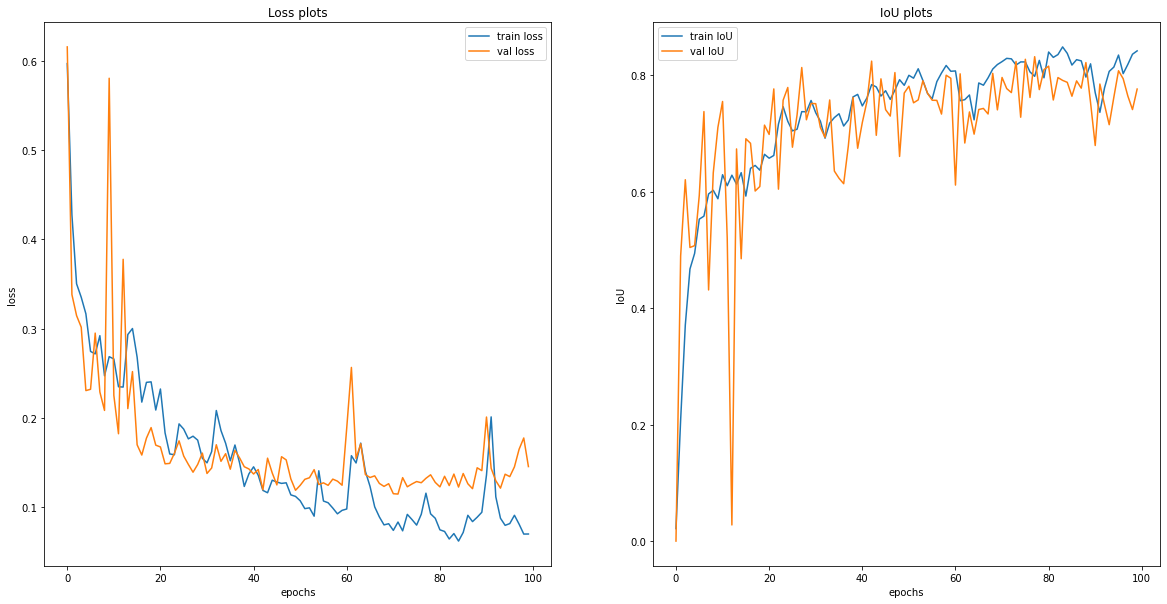

In [102]:
max_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
best_model_segnet_focal = train(model, optimizer, focal_loss, max_epochs, data_tr, data_val, iou_pytorch, threshold=0.9)

In [516]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_segnet_focal, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.7002621241257738


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.7622548623956168


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.7936867368221288


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.815115223343556


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.8317171798302576


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.8428151484636162


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8491107105291803


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.8489511025410433


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.8322766449818245


In [527]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_segnet_focal, iou_pytorch, data_ts, threshold=0.7)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8385439492647465


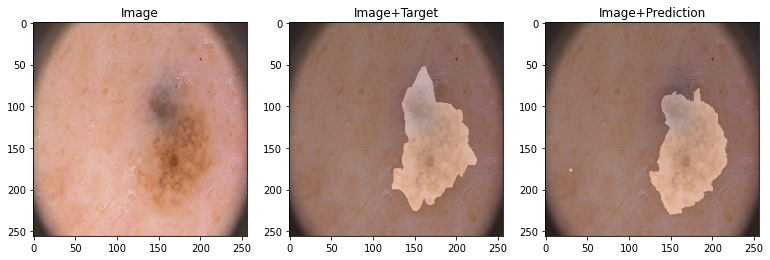

In [518]:
# бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_segnet_focal, X.to(device), threshold=0.7)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [320]:
# torch.save(best_model_segnet_focal.state_dict(), 'SegNet_Focal.pth')

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты? 

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой 

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

Реализуем Lovasz Loss


Автор: Maxim Berman  
Статья: https://arxiv.org/pdf/1705.08790.pdf  
GitHub: https://github.com/bermanmaxim/LovaszSoftmax

<a id='lovasz_loss'></a>

In [128]:
from torch.autograd import Variable
from torch.nn import functional as F

def flatten_binary_scores(scores, labels, ignore=None):
    """
    Flattens predictions in the batch (binary case)
    Remove labels equal to 'ignore'
    """
    scores = scores.view(-1)
    labels = labels.view(-1)
    if ignore is None:
        return scores, labels
    valid = (labels != ignore)
    vscores = scores[valid]
    vlabels = labels[valid]
    return vscores, vlabels

def lovasz_grad(gt_sorted):
    """
    Computes gradient of the Lovasz extension w.r.t sorted errors
    See Alg. 1 in paper
    """
    p = len(gt_sorted)
    gts = gt_sorted.sum()
    intersection = gts - gt_sorted.float().cumsum(0)
    union = gts + (1 - gt_sorted).float().cumsum(0)
    jaccard = 1. - intersection / union
    if p > 1: # cover 1-pixel case
        jaccard[1:p] = jaccard[1:p] - jaccard[0:-1]
    return jaccard

def lovasz_hinge(logits, labels, per_image=True, ignore=None):
    """
    Binary Lovasz hinge loss
      logits: [B, H, W] Variable, logits at each pixel (between -\infty and +\infty)
      labels: [B, H, W] Tensor, binary ground truth masks (0 or 1)
      per_image: compute the loss per image instead of per batch
      ignore: void class id
    """
    if per_image:
        loss = mean(lovasz_hinge_flat(*flatten_binary_scores(log.unsqueeze(0), lab.unsqueeze(0), ignore))
                          for log, lab in zip(logits, labels))
    else:
        loss = lovasz_hinge_flat(*flatten_binary_scores(logits, labels, ignore))
    return loss

def lovasz_hinge_flat(logits, labels):
    """
    Binary Lovasz hinge loss
      logits: [P] Variable, logits at each prediction (between -\infty and +\infty)
      labels: [P] Tensor, binary ground truth labels (0 or 1)
      ignore: label to ignore
    """
    if len(labels) == 0:
        # only void pixels, the gradients should be 0
        return logits.sum() * 0.
    signs = 2. * labels.float() - 1.
    errors = (1. - logits * Variable(signs))
    errors_sorted, perm = torch.sort(errors, dim=0, descending=True)
    perm = perm.data
    gt_sorted = labels[perm]
    grad = lovasz_grad(gt_sorted)
    loss = torch.dot(F.relu(errors_sorted), Variable(grad))
    return loss

In [129]:
def lovasz_loss(y_real, y_pred):
    y_pred = torch.sigmoid(y_pred)
    return lovasz_hinge(y_pred, y_real, per_image=False)

In [130]:
model = SegNet().to(device)

<a id='segnet_lovasz'></a>

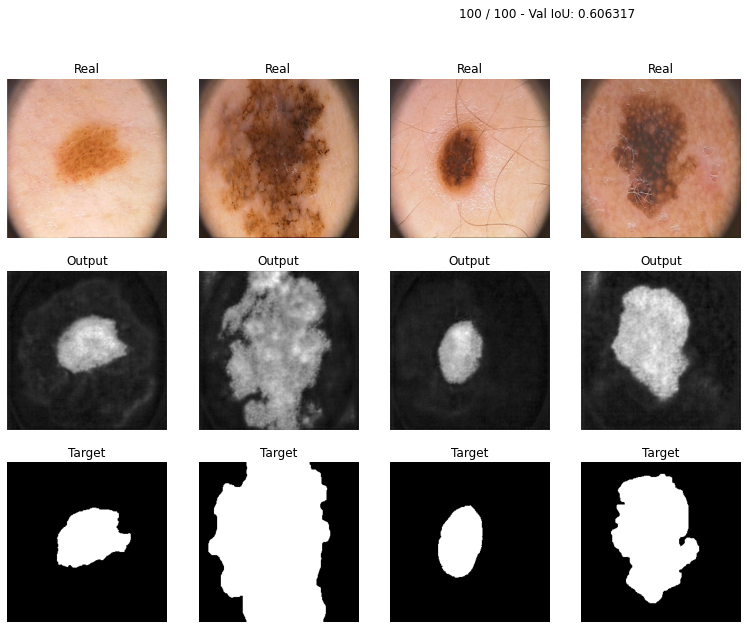

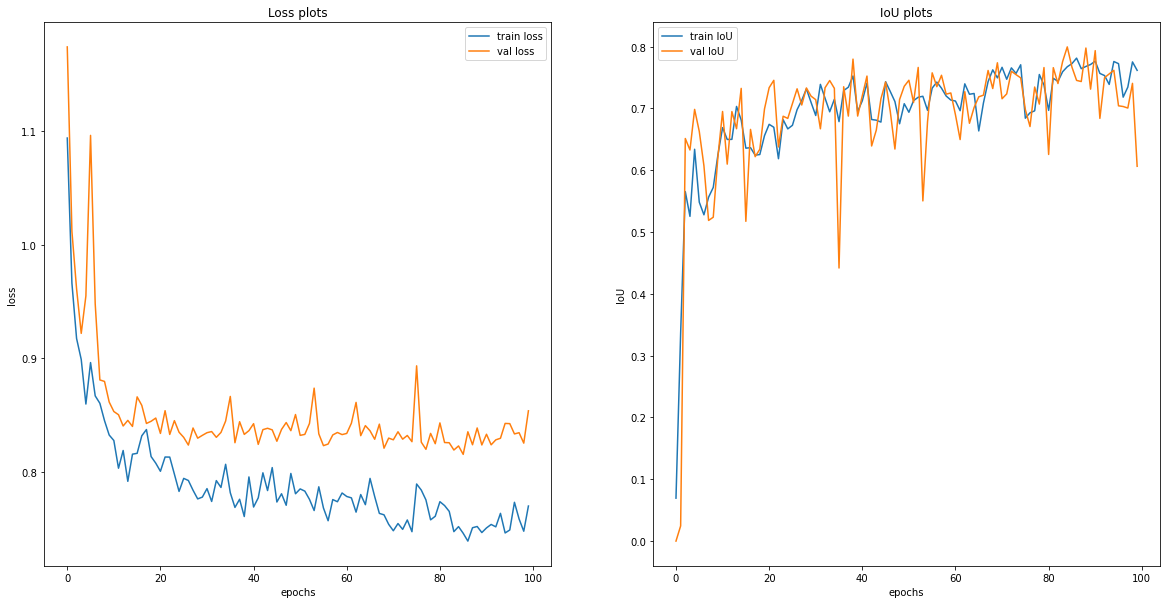

In [131]:
max_epochs = 100
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4)
best_model_segnet_lovasz = train(model, optimizer, lovasz_loss, max_epochs, data_tr, data_val, iou_pytorch, threshold=0.9)

In [519]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_segnet_lovasz, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.8155359418804832


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.8149757535641011


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.8141017688237704


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.8117044627666473


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.8101698020788338


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.8076680706556028


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8053802765332735


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.8015239653220544


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.794382297029862


In [528]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_segnet_lovasz, iou_pytorch, data_ts, threshold=0.1)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8344801345696815


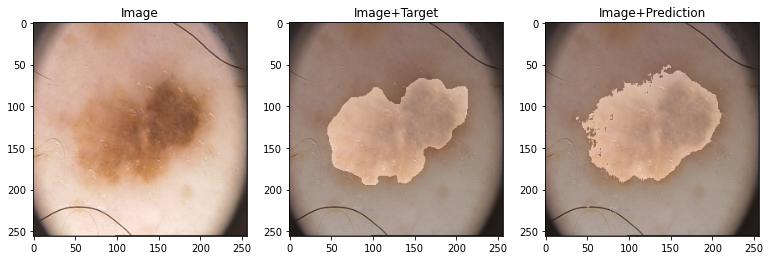

In [521]:
# бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_segnet_lovasz, X.to(device), threshold=0.1)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [321]:
# torch.save(best_model_segnet_lovasz.state_dict(), 'SegNet_Lovasz.pth')

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

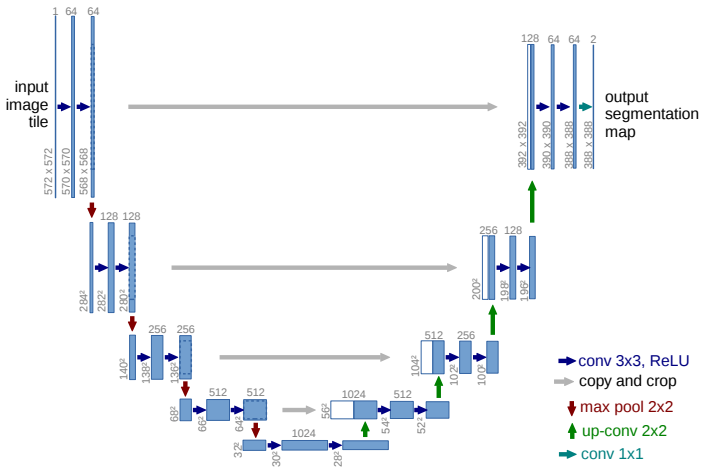

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-connections*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.
<a id='unet'></a>

In [157]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.MaxPool2d(kernel_size=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.MaxPool2d(kernel_size=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.MaxPool2d(kernel_size=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.MaxPool2d(kernel_size=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(scale_factor=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.Upsample(scale_factor=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.Upsample(scale_factor=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.Upsample(scale_factor=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_pool = self.pool0(e0)
        e1 = self.enc_conv1(e0_pool)
        e1_pool = self.pool1(e1)
        e2 = self.enc_conv2(e1_pool)
        e2_pool = self.pool2(e2)
        e3 = self.enc_conv3(e2_pool)
        e3_pool = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_pool)

        # decoder
#         print(torch.cat((e3, self.upsample0(b)), 0).shape)
        d0 = self.dec_conv0(torch.cat((e3, self.upsample0(b)), 1))
        d1 = self.dec_conv1(torch.cat((e2, self.upsample1(d0)), 1))
        d2 = self.dec_conv2(torch.cat((e1, self.upsample2(d1)), 1))
        d3 = self.dec_conv3(torch.cat((e0, self.upsample3(d2)), 1)) # no activation
        return d3

In [158]:
model = UNet().to(device)

In [159]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      590,

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─MaxPool2d: 1-2                         --
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─MaxPool2d: 1-4                         --
├─Sequential: 1-5                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                      590,

<a id='unet_bce'></a>

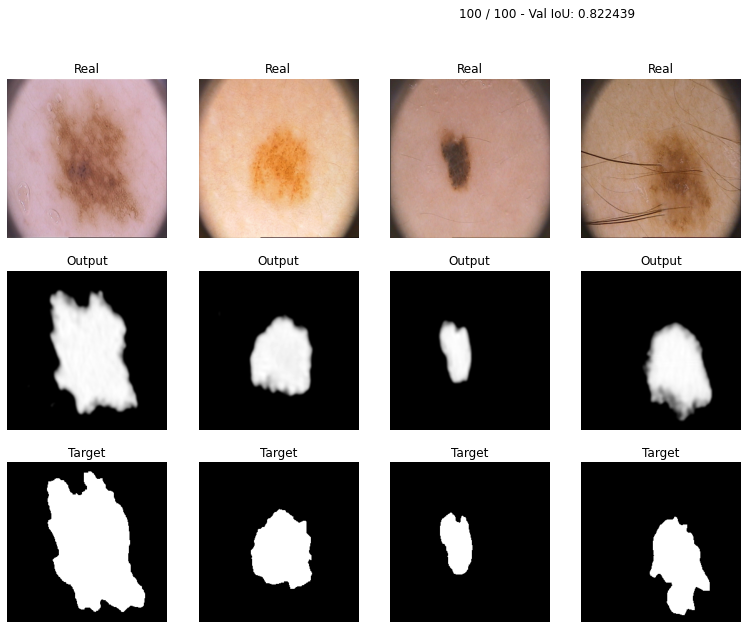

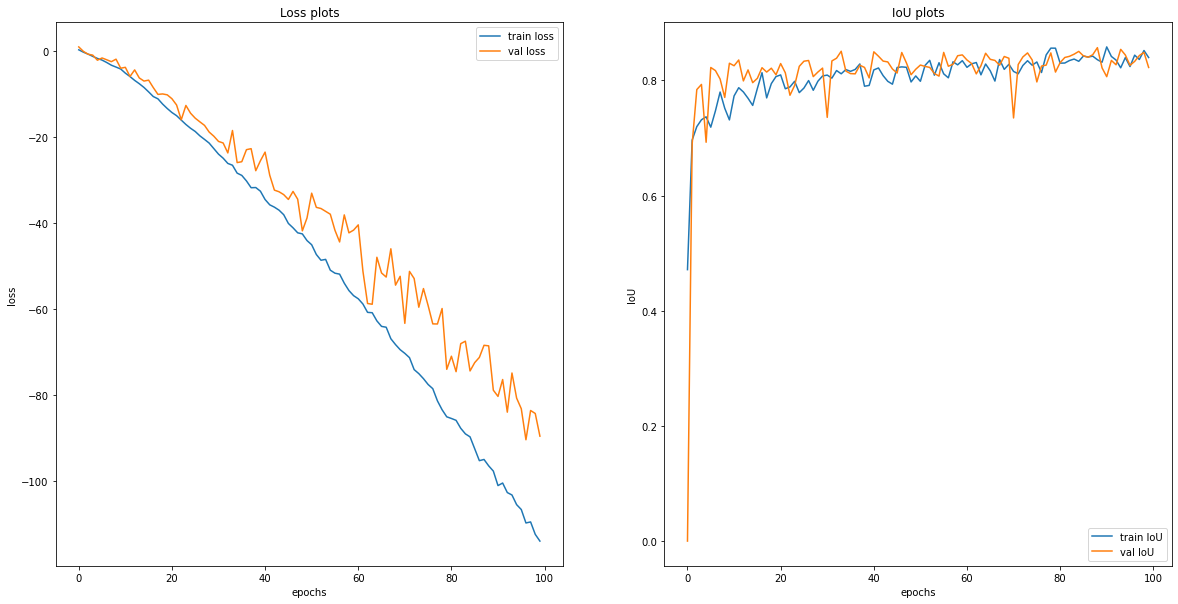

In [160]:
best_model_unet_bce = train(model, 
                        optim.AdamW(model.parameters(), lr=1e-4), bce_loss, 100, data_tr, data_val, iou_pytorch, threshold=0.9)

In [522]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_unet_bce, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.2703211388221154


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.27015040177565347


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.2705412967388446


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.2702745965810922


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.2705066739595852


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.8517451367928434


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8519655702664304


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.8531367026384059


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.8538636279564639


In [529]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_unet_bce, iou_pytorch, data_ts, threshold=0.9)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8618209764132132


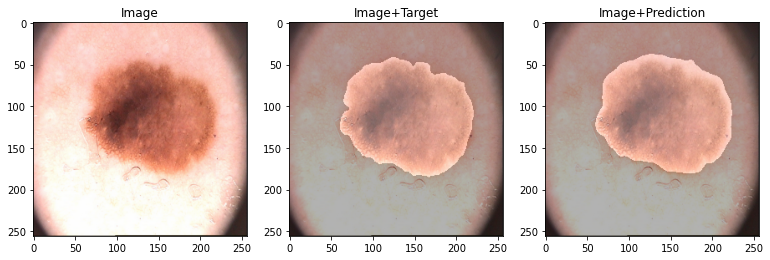

In [524]:
# бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_unet_bce, X.to(device), threshold=0.9)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [322]:
# torch.save(best_model_unet_bce.state_dict(), 'UNet_BCE.pth')

**UNet Dice Loss**
<a id='unet_dice'></a>

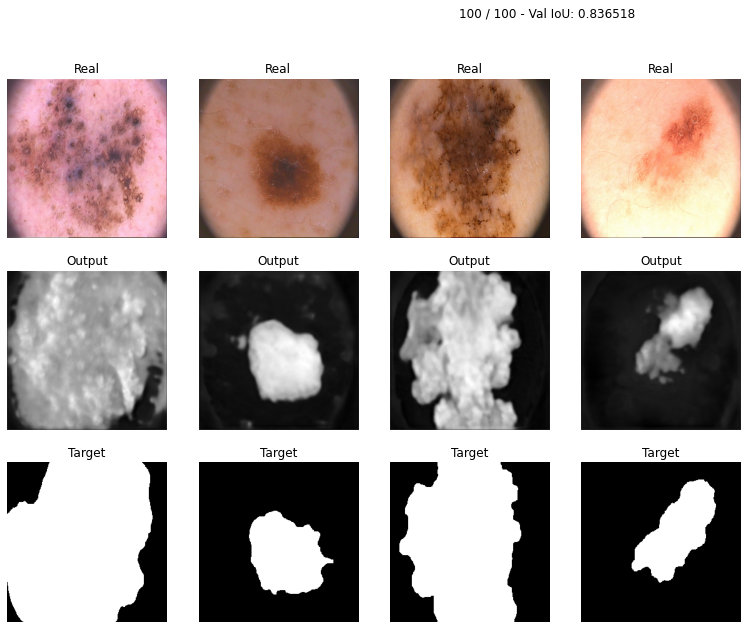

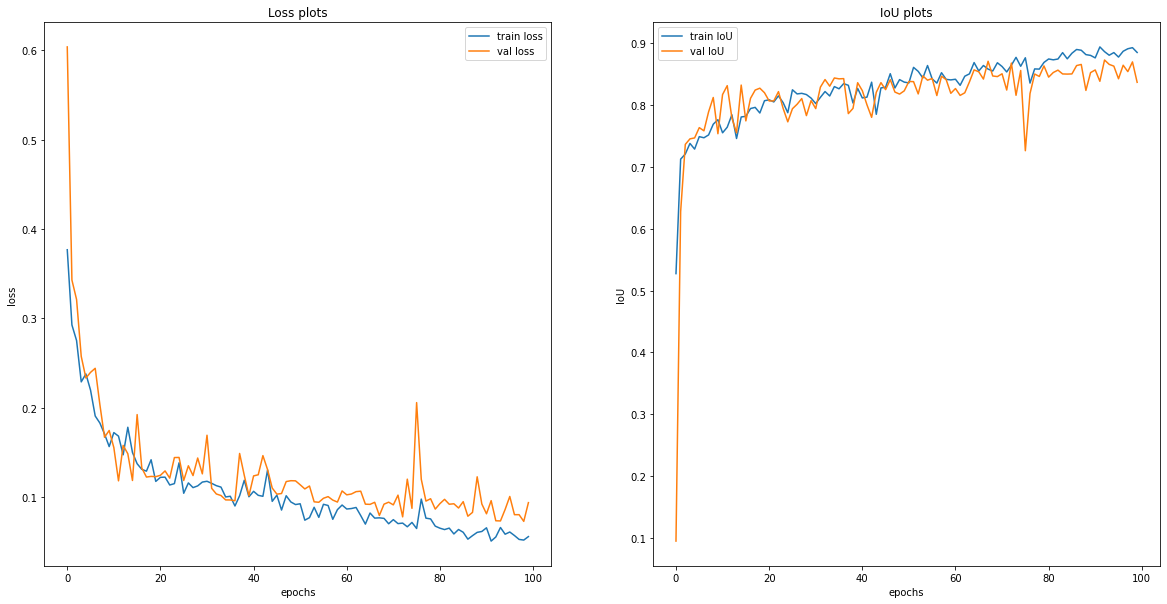

In [193]:
model = UNet().to(device)
best_model_unet_dice = train(model, 
                        optim.AdamW(model.parameters(), lr=1e-4), dice_loss, 100, data_tr, data_val, iou_pytorch, threshold=0.9)

In [530]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_unet_dice, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.8664584616514354


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.8677972237880411


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.8680136422469065


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.8690960288047788


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.8691263725207403


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.8695512355749423


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8699285103266053


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.8703896075945633


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.8696232450925389


In [559]:
score = 0
for _ in tqdm(range(100)):
    # максимум достигнут на 0.8, однако
    # 2 из 3 максимумов (SegNet и UNet2) достигаются на 0.9; для честного сравнения возьмём 0.9
    score += score_model(best_model_unet_dice, iou_pytorch, data_ts, threshold=0.9)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8892006869499502


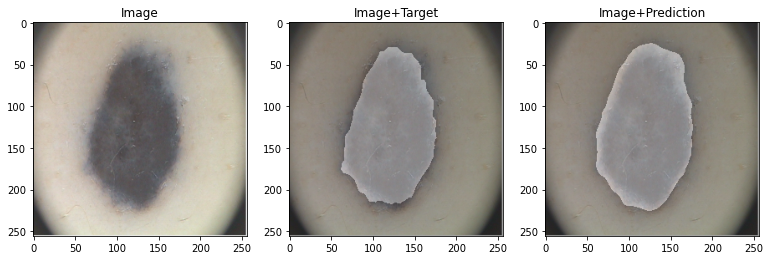

In [538]:
# бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_unet_dice, X.to(device), threshold=0.8)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [323]:
# torch.save(best_model_unet_dice.state_dict(), 'UNet_Dice.pth')

**UNet Focal Loss**
<a id='unet_focal'></a>

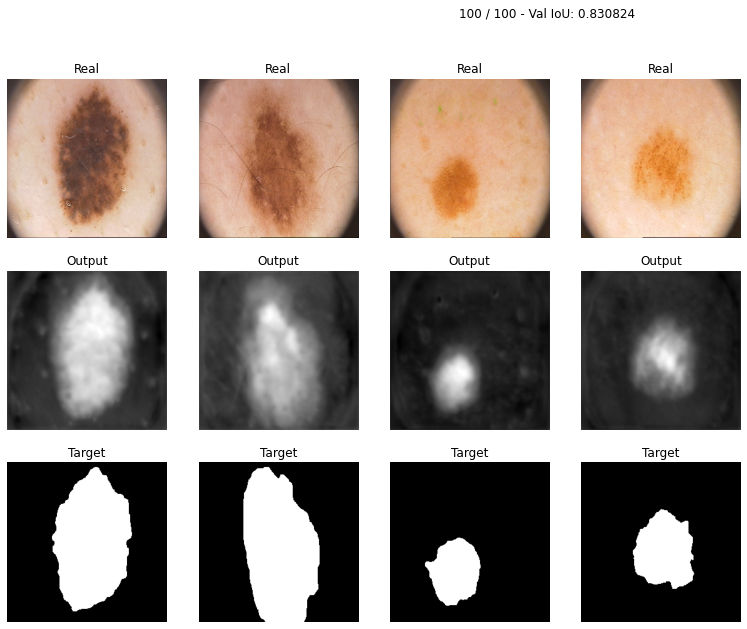

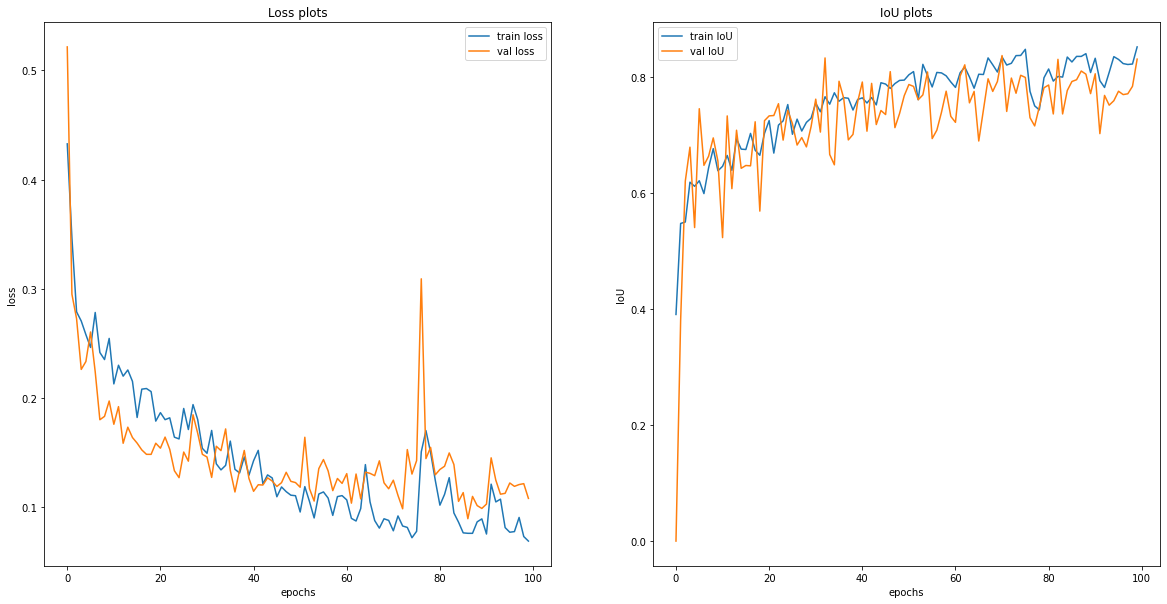

In [257]:
model = UNet().to(device)
best_model_unet_focal = train(model, 
                                optim.AdamW(model.parameters(), lr=1e-4), 
                                focal_loss, 100, data_tr, data_val, iou_pytorch, threshold=0.9)

In [534]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_unet_focal, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.6962247697894389


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.7651433903666642


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.8021515771975883


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.8272694220909707


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.8452370963646816


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.857763329377541


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8642964096252734


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.861659811093257


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.8381780457038143


In [539]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_unet_focal, iou_pytorch, data_ts, threshold=0.7)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8582278959567732


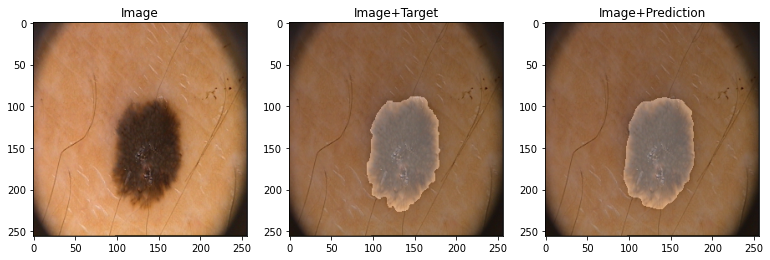

In [540]:
# бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_unet_focal, X.to(device), threshold=0.7)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [324]:
# torch.save(best_model_unet_focal.state_dict(), 'UNet_Focal.pth')

**UNet Lovasz Loss**
<a id='unet_lovasz'></a>

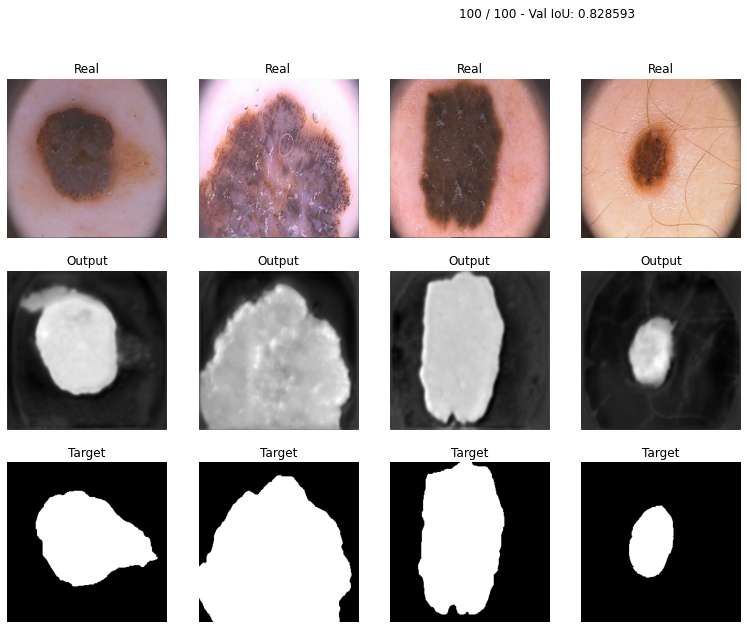

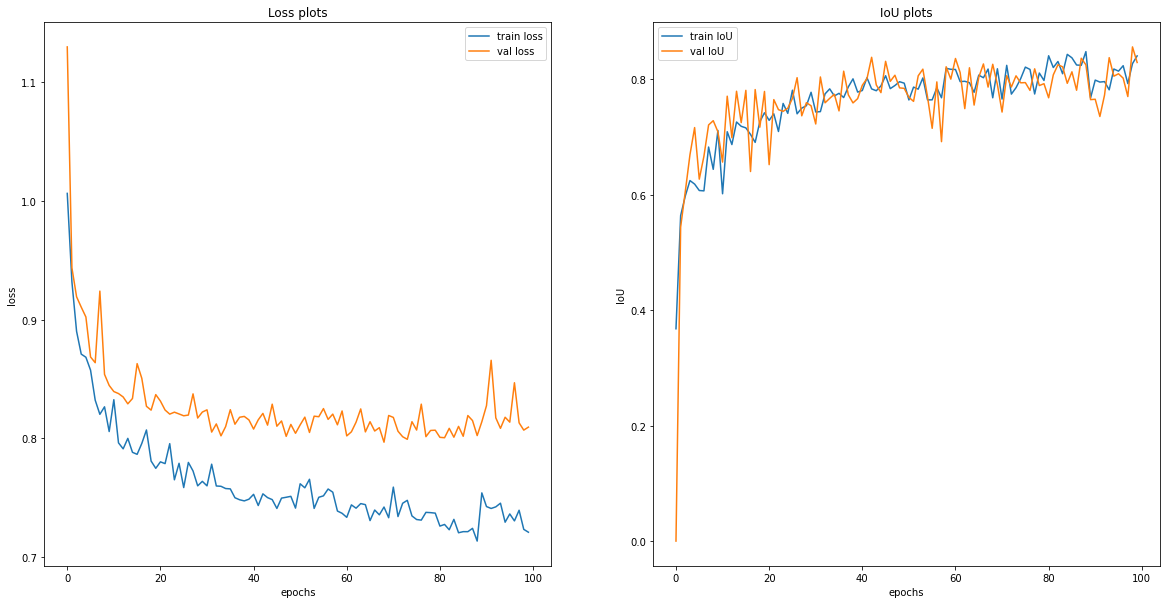

In [325]:
model = UNet().to(device)
best_model_unet_lovasz = train(model, 
                            optim.AdamW(model.parameters(), lr=1e-4), lovasz_loss, 100, 
                            data_tr, data_val, iou_pytorch, threshold=0.9)

In [541]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_unet_lovasz, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.8668190117982718


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.8664315457985956


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.8652099629090381


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.8646368335760556


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.8642581017659262


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.8624700731956042


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8611274598653499


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.8586933993376215


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.8537157279711507


In [542]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_unet_lovasz, iou_pytorch, data_ts, threshold=0.1)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8668644403494323


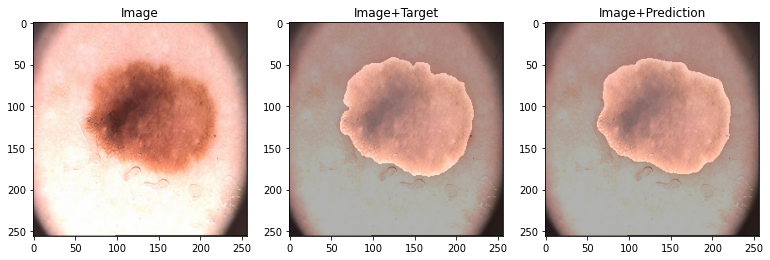

In [357]:
# бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_unet_lovasz, X.to(device), threshold=0.1)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [358]:
# torch.save(best_model_unet_lovasz.state_dict(), 'UNet_Lovasz.pth')

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.
<a id='unet2'></a>

In [359]:
class UNet2(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        # Each enc_conv/dec_conv block should look like this:
        # nn.Sequential(
        #     nn.Conv2d(...),
        #     ... (2 or 3 conv layers with relu and batchnorm),
        # )
        self.enc_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.pool0 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 256 -> 128
        self.enc_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.pool1 = nn.Conv2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 128 -> 64
        self.enc_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.pool2 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 64 -> 32
        self.enc_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )
        self.pool3 = nn.Conv2d(in_channels=512, out_channels=512, kernel_size=2, stride=2) # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU()
        )

        # decoder (upsampling)
        self.upsample0 = nn.ConvTranspose2d(in_channels=512, out_channels=512, kernel_size=2, stride=2)  # 16 -> 32
        self.dec_conv0 = nn.Sequential(
            nn.Conv2d(in_channels=1024, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(),
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU()
        )
        self.upsample1 = nn.ConvTranspose2d(in_channels=256, out_channels=256, kernel_size=2, stride=2) # 32 -> 64
        self.dec_conv1 = nn.Sequential(
            nn.Conv2d(in_channels=512, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU()
        )
        self.upsample2 = nn.ConvTranspose2d(in_channels=128, out_channels=128, kernel_size=2, stride=2) # 64 -> 128
        self.dec_conv2 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.upsample3 = nn.ConvTranspose2d(in_channels=64, out_channels=64, kernel_size=2, stride=2) # 128 -> 256
        self.dec_conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.Conv2d(in_channels=64, out_channels=1, kernel_size=3, padding=1)
        )

    def forward(self, x):
        # encoder
        e0 = self.enc_conv0(x)
        e0_pool = self.pool0(e0)
        e1 = self.enc_conv1(e0_pool)
        e1_pool = self.pool1(e1)
        e2 = self.enc_conv2(e1_pool)
        e2_pool = self.pool2(e2)
        e3 = self.enc_conv3(e2_pool)
        e3_pool = self.pool3(e3)

        # bottleneck
        b = self.bottleneck_conv(e3_pool)

        # decoder
#         print(torch.cat((e3, self.upsample0(b)), 0).shape)
        d0 = self.dec_conv0(torch.cat((e3, self.upsample0(b)), 1))
        d1 = self.dec_conv1(torch.cat((e2, self.upsample1(d0)), 1))
        d2 = self.dec_conv2(torch.cat((e1, self.upsample2(d1)), 1))
        d3 = self.dec_conv3(torch.cat((e0, self.upsample3(d2)), 1)) # no activation
        return d3

**UNet2 BCE Loss**

In [360]:
model = UNet2().to(device)

In [361]:
summary(model)

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Conv2d: 1-2                            16,448
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Conv2d: 1-4                            65,664
├─Sequential: 1-5                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                  

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Conv2d: 2-1                       1,792
|    └─BatchNorm2d: 2-2                  128
|    └─ReLU: 2-3                         --
|    └─Conv2d: 2-4                       36,928
|    └─BatchNorm2d: 2-5                  128
|    └─ReLU: 2-6                         --
├─Conv2d: 1-2                            16,448
├─Sequential: 1-3                        --
|    └─Conv2d: 2-7                       73,856
|    └─BatchNorm2d: 2-8                  256
|    └─ReLU: 2-9                         --
|    └─Conv2d: 2-10                      147,584
|    └─BatchNorm2d: 2-11                 256
|    └─ReLU: 2-12                        --
├─Conv2d: 1-4                            65,664
├─Sequential: 1-5                        --
|    └─Conv2d: 2-13                      295,168
|    └─BatchNorm2d: 2-14                 512
|    └─ReLU: 2-15                        --
|    └─Conv2d: 2-16                  

<a id='unet2_bce'></a>

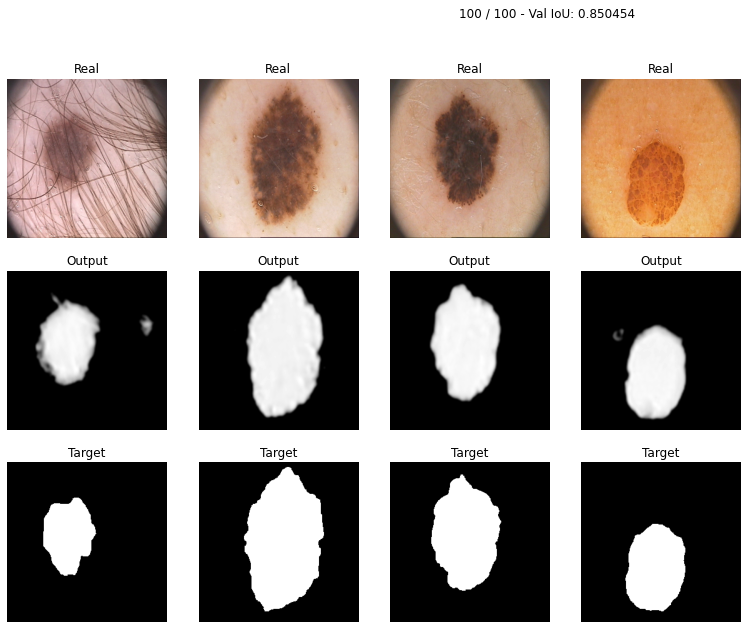

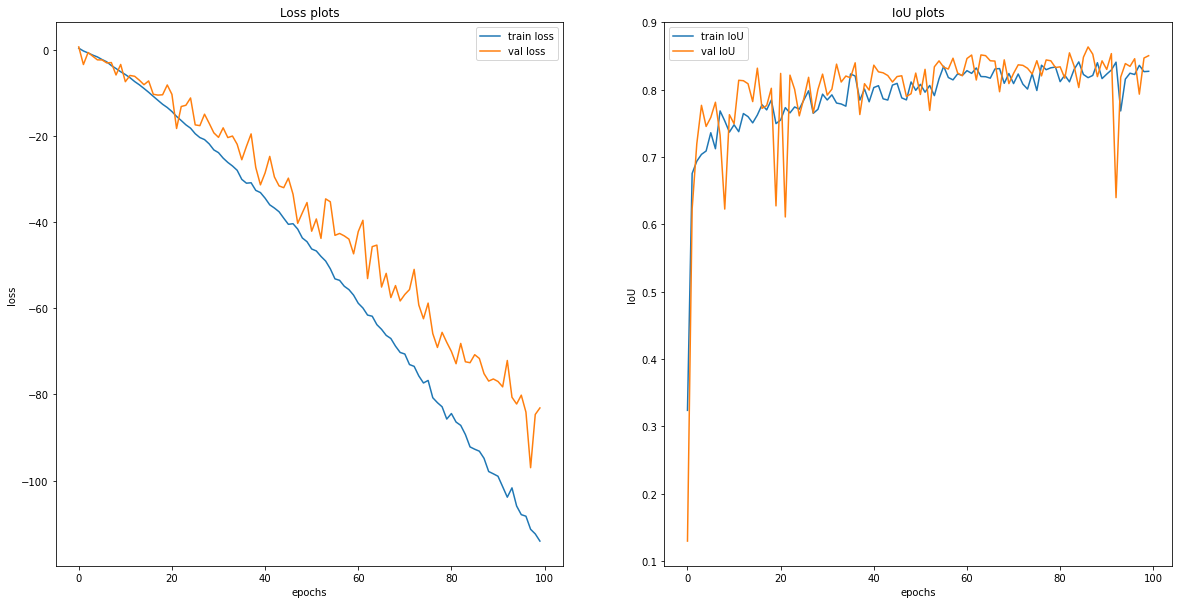

In [362]:
best_model_unet2_bce = train(model, 
                            optim.AdamW(model.parameters(), lr=1e-4), 
                            bce_loss, 100, data_tr, data_val, iou_pytorch, threshold=0.9)

In [543]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_unet2_bce, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.27075367560753466


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.27048166128305273


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.27128035618708696


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.2723286056518555


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.2710161326481746


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.8593975367912879


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8598744293359611


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.8609363893820692


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.8622429097615754


In [544]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_unet2_bce, iou_pytorch, data_ts, threshold=0.9)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8553878850661788


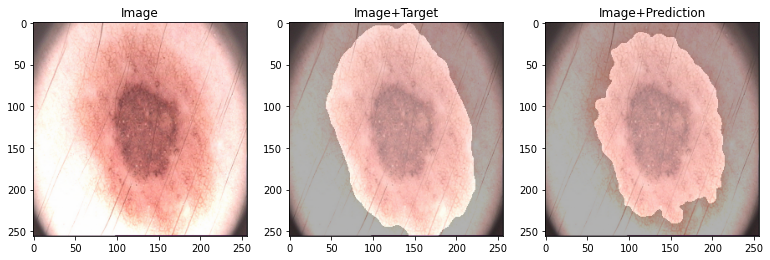

In [545]:
### бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_unet2_bce, X.to(device), threshold=0.9)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [388]:
# torch.save(best_model_unet2_bce.state_dict(), 'UNet2_BCE.pth')

**UNet2 Dice Loss**
<a id='unet2_dice'></a>

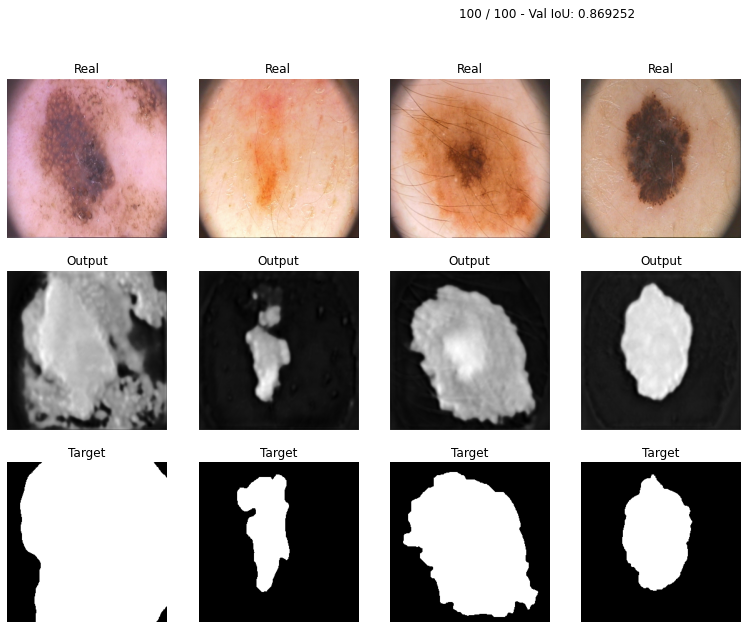

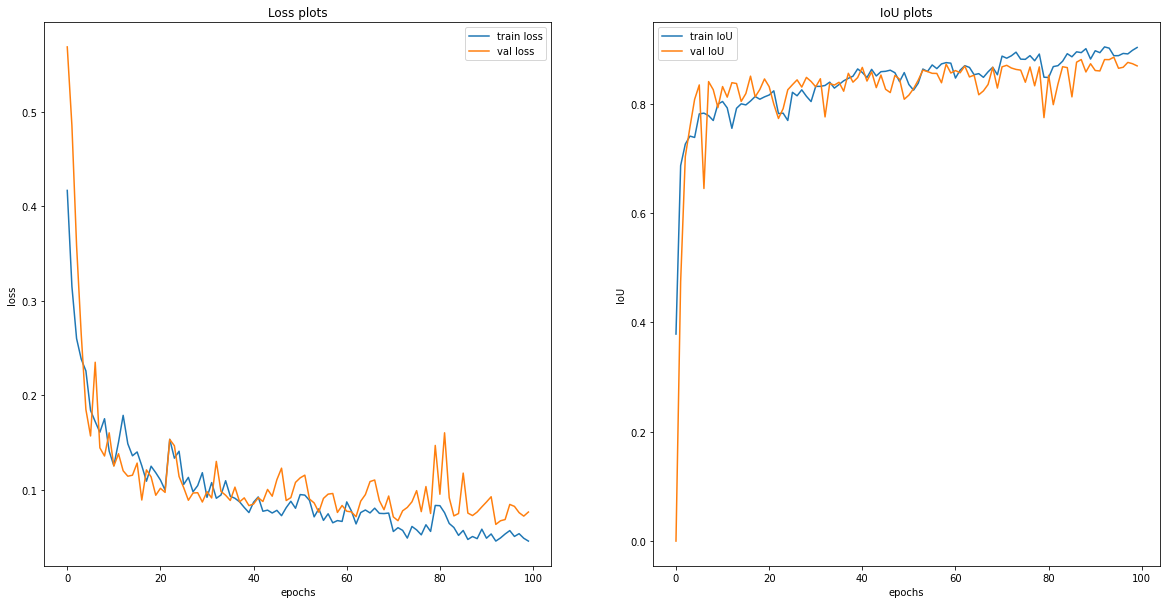

In [389]:
model = UNet2().to(device)
best_model_unet2_dice = train(model, 
                                 optim.AdamW(model.parameters(), lr=1e-4), 
                                 dice_loss, 100, data_tr, data_val, iou_pytorch, threshold=0.9)

In [546]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_unet2_dice, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.8713771195136583


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.8742218915315775


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.8761516126761073


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.8770076933273905


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.8781786481921489


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.8796966888812875


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8803372655006558


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.8814232311340479


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.8829725140333177


In [547]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_unet2_dice, iou_pytorch, data_ts, threshold=0.9)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8673634329208956


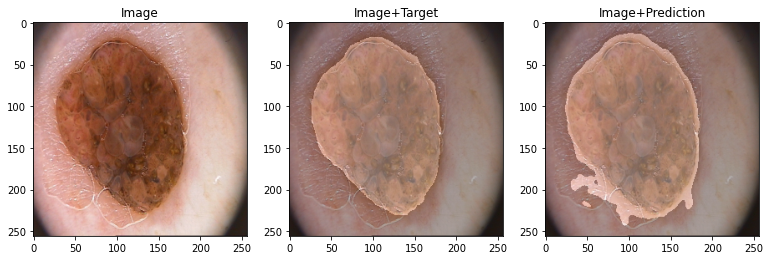

In [549]:
### бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_unet2_dice, X.to(device), threshold=0.9)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [422]:
# torch.save(best_model_unet2_dice.state_dict(), 'UNet2_Dice.pth')

**UNet2 Focal Loss**
<a id='unet2_focal'></a>

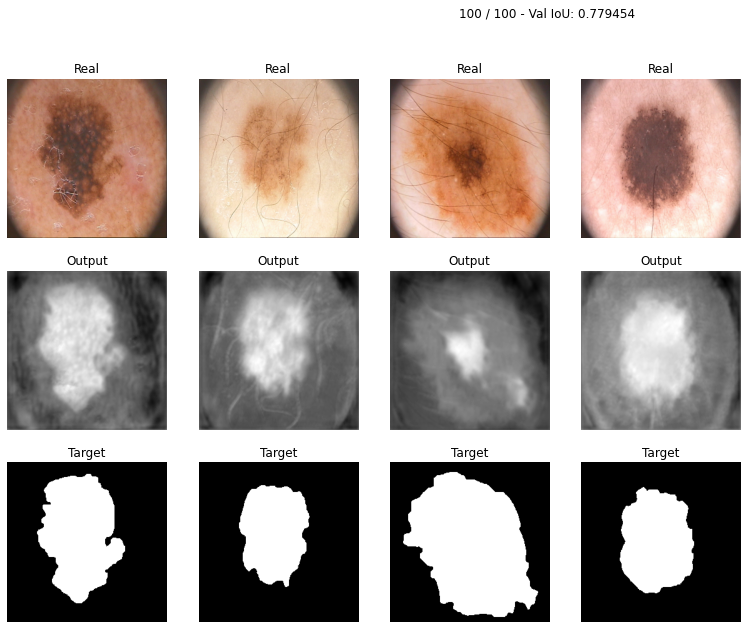

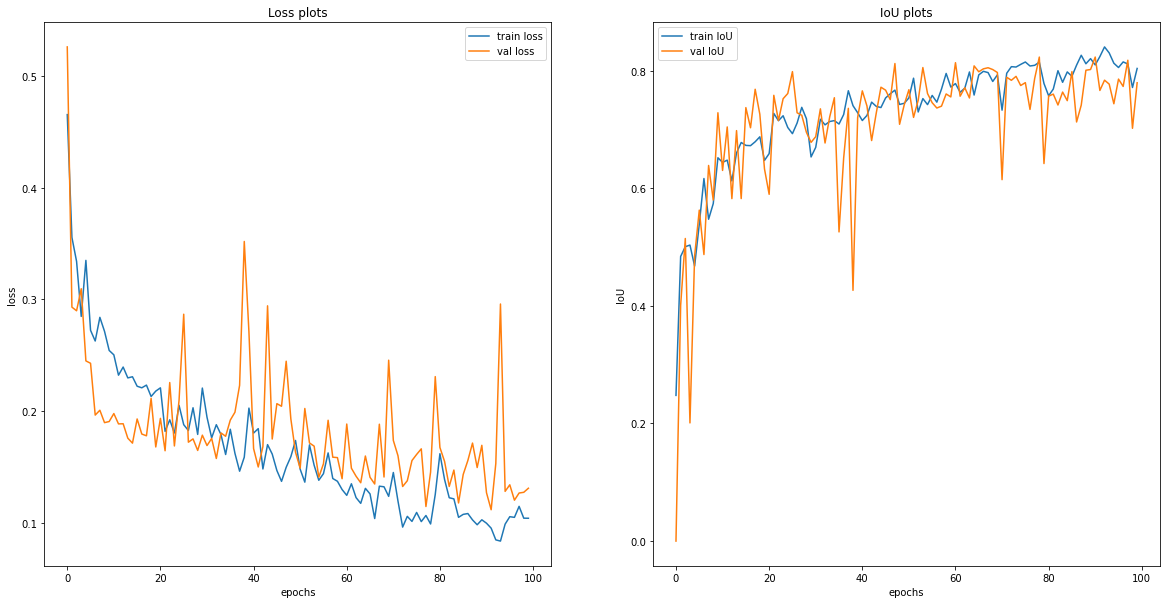

In [423]:
model = UNet2().to(device)
best_model_unet2_focal = train(model, 
                                optim.AdamW(model.parameters(), lr=1e-4), 
                                focal_loss, 100, data_tr, data_val, iou_pytorch, threshold=0.9)

In [550]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_unet2_focal, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.7266614440083505


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.7899894979825384


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.8232769145415375


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.8435119772874393


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.855169214239487


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.8617361796360751


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8623937307871306


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.851785305692599


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.8234269150862326


In [551]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_unet2_focal, iou_pytorch, data_ts, threshold=0.7)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8764509418377507


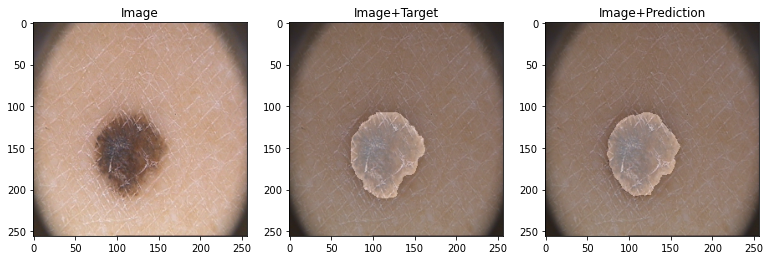

In [552]:
### бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_unet2_focal, X.to(device), threshold=0.7)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [445]:
# torch.save(best_model_unet2_focal.state_dict(), 'UNet2_Focal.pth')

**UNet2 Lovasz Loss**
<a id='unet2_lovasz'></a>

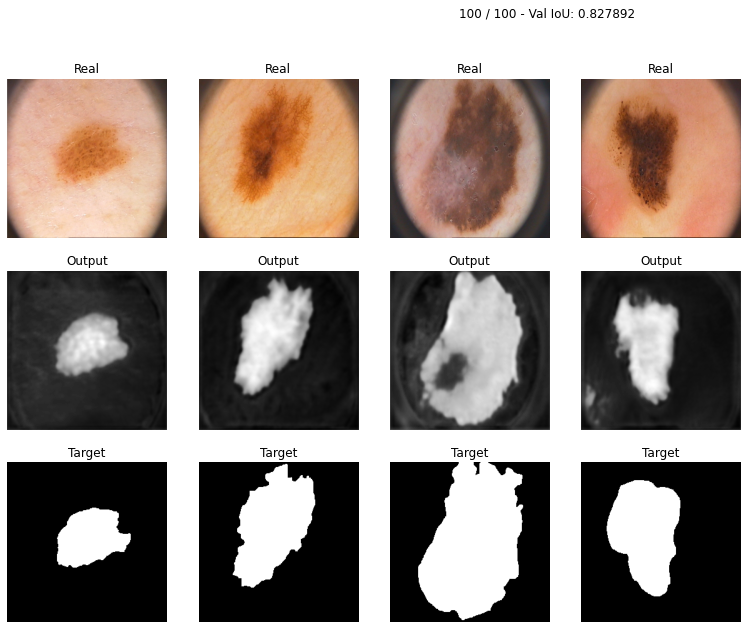

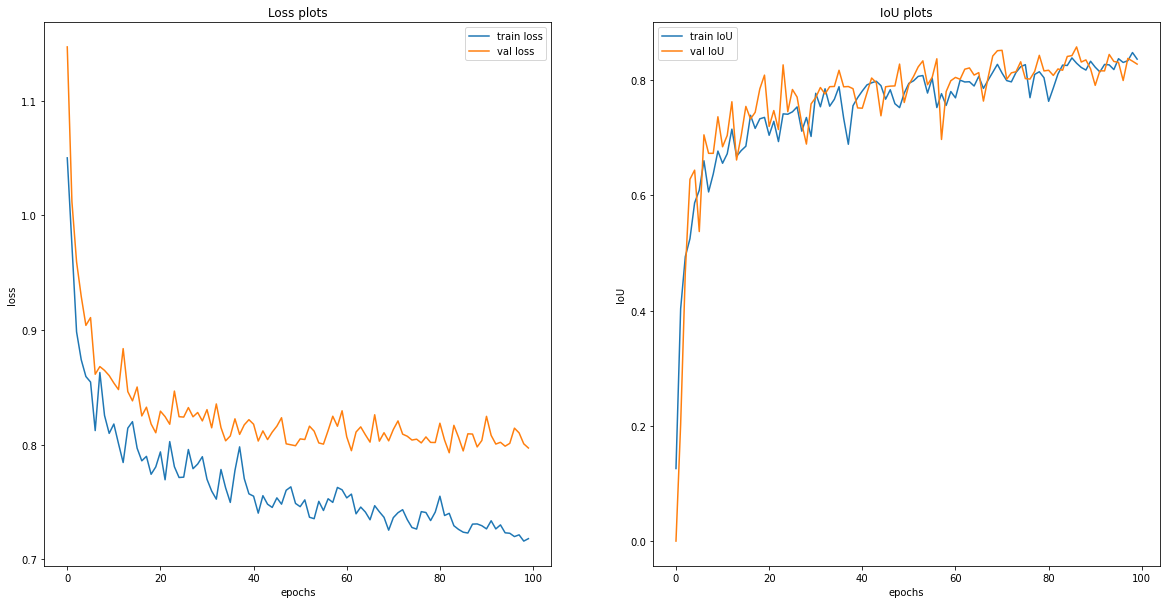

In [446]:
model = UNet2().to(device)
best_model_unet2_lovasz = train(model, 
                                optim.AdamW(model.parameters(), lr=1e-4), 
                                lovasz_loss, 100, data_tr, data_val, iou_pytorch, threshold=0.9)

In [553]:
for th in tqdm(np.round(np.arange(0.1, 1, 0.1), 1)):
    score = 0
    for _ in tqdm(range(100)):
        score += score_model(best_model_unet2_lovasz, iou_pytorch, data_val, threshold=th)
    print('Threshold:', th, 'Mean IoU:', score / 100)

  0%|          | 0/9 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.1 Mean IoU: 0.8638936135402088


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.2 Mean IoU: 0.8648570439448724


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.3 Mean IoU: 0.8652625792301617


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.4 Mean IoU: 0.8644654543583208


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.5 Mean IoU: 0.864530729055405


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.6 Mean IoU: 0.8640077387828099


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.7 Mean IoU: 0.8635964836982588


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.8 Mean IoU: 0.8613943618994493


  0%|          | 0/100 [00:00<?, ?it/s]

Threshold: 0.9 Mean IoU: 0.8587570570065425


In [557]:
score = 0
for _ in tqdm(range(100)):
    # максимум достигнут на 0.3, однако
    # 2 из 3 максимумов (SegNet и UNet) достигаются на 0.1; для честного сравнения возьмём 0.1
    score += score_model(best_model_unet2_lovasz, iou_pytorch, data_ts, threshold=0.1)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8710187026629079


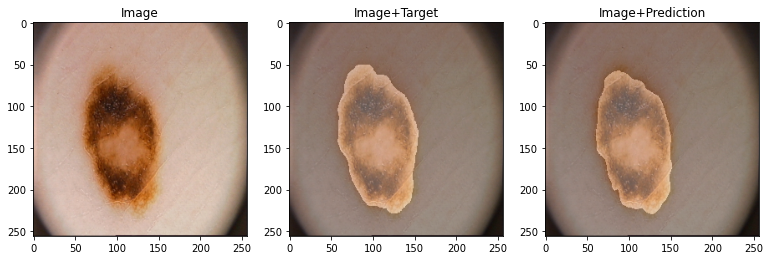

In [558]:
### бинаризованные предсказания
X, Y = next(iter(data_ts))
preds = predict(best_model_unet2_lovasz, X.to(device), threshold=0.1)
_, axes = plt.subplots(1, 3, figsize=(13, 8))

axes[0].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[0].set_title('Image')

axes[1].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[1].imshow(np.moveaxis(Y[0].numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[1].set_title('Image+Target')

axes[2].imshow(np.moveaxis(X[0].numpy(), 0, 2), cmap='gray')
axes[2].imshow(np.moveaxis(preds[0].cpu().numpy(), 0, 2), cmap='gray', alpha=0.3)
axes[2].set_title('Image+Prediction');

In [474]:
# torch.save(best_model_unet2_lovasz.state_dict(), 'UNet2_Lovasz.pth')

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов): 
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте. 
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии: 

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.

In [560]:
score = 0
for _ in tqdm(range(100)):
    score += score_model(best_model_unet_dice, iou_pytorch, data_ts, threshold=0.8)
print('Mean IoU:', score / 100)

  0%|          | 0/100 [00:00<?, ?it/s]

Mean IoU: 0.8895814232642834


### Описание

В работе были использованы следующие архитектуры:
- [SegNet](#segnet)
- [UNet](#unet)
- [Unet2](#unet2)

В качестве оптимизатора был использован AdamW, как показаваший наилучшую скорость сходимости и устойчивость. Learning Rate = 1e-4

Были использованы следующие Loss'ы:
- [BCE](#bce_loss)
- [Dice](#dice_loss)
- [Focal](#focal_loss)
- [Lovasz](#lovasz_loss) (близок по смыслу к оптимизации IoU)

Выборка была разделена на 3 группы:
- обучающая (100 картинок)
- валидационная (50 картинок)
- тестовая (50 картинок)

Размер батча выбран равным 4 для того, чтобы обучение уместилось в память GPU (NVIDIA GeForce RTX 2070 SUPER 8 GB)

Обучение проводилось на 100 эпохах.  
По итогам выбиралась сеть, показавшая наивысший скор IoU на валидационной выборке (порог 0.9).

Бинаризация логитов (выходов сети) производилась путём применения сигмоиды и задания порога [0.1; 0.9].  
Разные лоссы дают разную картинку на выходе из сети, поэтому для разных лоссов подбирался свой порог бинаризации для достижения наивысшего скора IoU на валидационной выборке. Подобранные пороги указаны в таблице результатов.

### Результаты

||SegNet|UNet|UNet2|Порог|
|-|-|-|-|-|
|BCE|[0.84](#segnet_bce)|[0.86](#unet_bce)|[0.85](#unet2_bce)|0.9|
|Dice|[0.87](#segnet_dice)|[0.889](#unet_dice)|[0.86](#unet2_dice)|0.9|
|Focal|[0.83](#segnet_focal)|[0.85](#unet_focal)|[0.87](#unet2_focal)|0.7|
|Lovasz|[0.83](#segnet_lovasz)|[0.86](#unet_lovasz)|[0.87](#unet2_lovasz)|0.1|

<center><i>*Значения кликабельны</i></center>

Для каждого рассмотренного случая выведена следующая информация (в порядке следования)(для просмотра можно перейти по ссылкам в таблице):
- Изображения - 4 случайных картинки из валидационной выборки
    - Реальные изображения
    - Выходы сети (логиты)
    - Целевая разметка картинки (таргеты)
- Графики
    - Лоссы по эпохам: на обучающей и валидационной выборках
    - Метрика IoU по эпохам: на обучающей и валидационной выборках
- Метрика IoU 
    - на валидационной выборке (приблизительная)
    - на тестовой выборке с подобранным порогом бинаризации
- Изображения - 1 случайная картинка из тестовой выборки
    - Реальная картинка
    - Реальная картинка с наложенной целевой маской 
    - Реальная картинка с наложенной инференс-маской
    
### Выводы

Лоссы: Наилучший IoU достигается при Dice loss. Focal loss имеет большую дисперсию (исходя из графиков), поэтому данный лосс может на новых датасетах показывать нестабильный результат. Lovasz loss не показал лучших результатов.

Модели: UNet на всех лоссах показал результат, лучший чем SegNet.  
UNet2 показал лучший результат, чем UNet на Focal и Lovasz, и худший на BCE и на Dice. Однозначно определить, какая из этих двух моделей лучше не получается по данным лоссам.  
Наилучший результат показала сеть **UNet** + **Dice loss. Порог: 0.8 IoU: 0.8895814232642834**